# Enhanced Matomo Analytics: User Behavior and Bot Detection Analysis

This notebook provides a comprehensive analysis of Matomo web analytics data, focusing on:

1. Sophisticated Bot Detection
2. In-depth User Behavior Analysis
3. Geographic Distribution with Country Details
4. Advanced User Segmentation
5. Actionable Insights Generation

We'll use machine learning and statistical analysis to uncover meaningful patterns in user behavior while effectively filtering out bot traffic.

In [2]:
!pip install plotly pandas numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]2m1/2 [plotly]


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pycountry
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Data Loading and Initial Processing

Let's load and process the three main Matomo log tables:
1. `log_visit`: Contains visit-level information and metrics
2. `log_link_visit_action`: Contains detailed page view and interaction data
3. `log_action`: Contains information about URLs and actions

We'll clean and preprocess the data before analysis.

In [4]:
# Load the raw datasets
log_visit = pd.read_csv('exported_tables/matomo_log_visit.csv', on_bad_lines='skip')
log_link_visit = pd.read_csv('exported_tables/matomo_log_link_visit_action.csv')
log_action = pd.read_csv('exported_tables/matomo_log_action.csv')

# Display basic information about datasets
print("Dataset Dimensions:")
print(f"log_visit: {log_visit.shape}")
print(f"log_link_visit: {log_link_visit.shape}")
print(f"log_action: {log_action.shape}")

Dataset Dimensions:
log_visit: (1000, 60)
log_link_visit: (1000, 41)
log_action: (1000, 5)


In [5]:
# Function to clean log_visit data
def clean_log_visit(df):
    df_clean = df.copy()
    
    # Convert timestamps to datetime
    time_columns = ['visit_first_action_time', 'visit_last_action_time']
    for col in time_columns:
        df_clean[col] = pd.to_datetime(df_clean[col])
    
    # Fill missing values
    df_clean['visit_total_time'] = df_clean['visit_total_time'].fillna(0)
    df_clean['visit_total_actions'] = df_clean['visit_total_actions'].fillna(0)
    df_clean['visitor_returning'] = df_clean['visitor_returning'].fillna(0)
    
    # Add derived features
    df_clean['visit_hour'] = df_clean['visit_first_action_time'].dt.hour
    df_clean['visit_day'] = df_clean['visit_first_action_time'].dt.day_name()
    df_clean['visit_month'] = df_clean['visit_first_action_time'].dt.month
    
    # Map country codes to full names
    df_clean['country_name'] = df_clean['location_country'].apply(
        lambda x: pycountry.countries.get(alpha_2=x).name if x and len(x)==2 
        else ('Unknown' if pd.isna(x) else x)
    )
    
    return df_clean

In [6]:
# Function to clean log_action data
def clean_log_action(df):
    df_clean = df.copy()
    
    # Create full URLs
    url_prefix_map = {
        0: 'http://',
        1: 'http://www.',
        2: 'https://',
        3: 'https://www.'
    }
    
    def build_full_url(row):
        if row['type'] in [1, 2, 3]:  # URL types
            prefix = url_prefix_map.get(row['url_prefix'], '')
            return prefix + str(row['name'])
        return str(row['name'])
    
    df_clean['full_url'] = df_clean.apply(build_full_url, axis=1)
    
    return df_clean[['idaction', 'full_url', 'type']]

In [7]:
# Clean the datasets
log_visit_clean = clean_log_visit(log_visit)
log_action_clean = clean_log_action(log_action)

In [8]:
# Merge datasets to create complete view
def create_complete_dataset():
    # First merge: log_link_visit with log_action
    visit_actions = pd.merge(
        log_link_visit,
        log_action_clean,
        left_on='idaction_url',
        right_on='idaction',
        how='left'
    )
    
    # Second merge: Add visit context
    complete_data = pd.merge(
        visit_actions,
        log_visit_clean,
        on='idvisit',
        how='left'
    )
    
    # Create additional metrics
    complete_data['time_per_action'] = (
        complete_data['visit_total_time'] / 
        complete_data['visit_total_actions'].clip(lower=1)
    )
    
    return complete_data

# Create final dataset
complete_data = create_complete_dataset()

# Display sample of processed data
print("\nSample of processed data:")
display(complete_data.head())


Sample of processed data:


,idlink_va,idsite_x,idvisitor_x,idvisit,idaction_url_ref,idaction_name_ref,custom_float,pageview_position,server_time,idpageview,idaction_name,idaction_url,search_cat,search_count,time_spent_ref_action,idaction_product_cat,idaction_product_cat2,idaction_product_cat3,idaction_product_cat4,idaction_product_cat5,idaction_product_name,product_price,idaction_product_sku,idaction_event_action,idaction_event_category,idaction_content_interaction,idaction_content_name,idaction_content_piece,idaction_content_target,time_dom_completion,time_dom_processing,time_network,time_on_load,time_server,time_transfer,time_spent,custom_dimension_1_x,custom_dimension_2_x,custom_dimension_3_x,custom_dimension_4_x,custom_dimension_5_x,idaction,full_url,type,idsite_y,idvisitor_y,visit_last_action_time,config_id,location_ip,profilable,user_id,visit_first_action_time,visit_goal_buyer,visit_goal_converted,visitor_returning,visitor_seconds_since_first,visitor_seconds_since_order,visitor_count_visits,visit_entry_idaction_name,visit_entry_idaction_url,visit_exit_idaction_name,visit_exit_idaction_url,visit_total_actions,visit_total_interactions,visit_total_searches,referer_keyword,referer_name,referer_type,referer_url,location_browser_lang,config_browser_engine,config_browser_name,config_browser_version,config_client_type,config_device_brand,config_device_model,config_device_type,config_os,config_os_version,visit_total_events,visitor_localtime,visitor_seconds_since_last,config_resolution,config_cookie,config_flash,config_java,config_pdf,config_quicktime,config_realplayer,config_silverlight,config_windowsmedia,visit_total_time,location_city,location_country,location_latitude,location_longitude,location_region,last_idlink_va,custom_dimension_1_y,custom_dimension_2_y,custom_dimension_3_y,custom_dimension_4_y,custom_dimension_5_y,visit_hour,visit_day,visit_month,country_name,time_per_action
0,1,1,<memory at 0x74a5a9a831c0>,1,0,0,NaN,1,2025-02-21 09:50:35,edNZua,1.000,2,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.000,326.000,NaN,575.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,2.000,http://localhost/rfq/buyer/generate-po?quoteId...,1.000,1.000,<memory at 0x74a5a9a82ec0>,2025-02-21 10:04:38,<memory at 0x74a5a9a82f80>,<memory at 0x74a5a9a82e00>,1.000,NaN,2025-02-21 09:50:35,0.000,0.000,0.000,0.000,NaN,1.000,1.000,2.000,1.000,4.000,7.000,7.000,0.000,NaN,NaN,1.000,http://localhost:4200/rfq/buyer/generate-po?qu...,en-us,Blink,CH,132.000,1.000,NaN,generic desktop,0.000,WIN,10.000,0.000,15:20:34,0.000,1920x1080,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,844.000,Mumbai,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN,9.000,Friday,2.000,India,120.571
1,2,1,<memory at 0x74a5a9a83040>,1,2,1,NaN,2,2025-02-21 09:50:35,L3xMsC,1.000,3,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000,305.000,NaN,558.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,3.000,http://localhost/rfq/sellers/rfq-list,1.000,1.000,<memory at 0x74a5a9a82ec0>,2025-02-21 10:04:38,<memory at 0x74a5a9a82f80>,<memory at 0x74a5a9a82e00>,1.000,NaN,2025-02-21 09:50:35,0.000,0.000,0.000,0.000,NaN,1.000,1.000,2.000,1.000,4.000,7.000,7.000,0.000,NaN,NaN,1.000,http://localhost:4200/rfq/buyer/generate-po?qu...,en-us,Blink,CH,132.000,1.000,NaN,generic desktop,0.000,WIN,10.000,0.000,15:20:34,0.000,1920x1080,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,844.000,Mumbai,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN,9.000,Friday,2.000,India,120.571
2,3,1,<memory at 0x74a5a9a83280>,1,3,1,NaN,3,2025-02-21 09:50:36,Yb1iEF,1.000,4,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.000,261.000,NaN,575.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,4.000,http://localhost/order-management,1.000,1.000,<memory at 0x74a5a9a82ec0>,2025-02-21 10:04:38,<memory at 0x74a5a9a82f80>,<memory at 0x74a5a9a82e00>,1.000,NaN,2025-02-21 09:50:35,0.000,0.000,0.000,0.000,NaN,1.000,1.000,2.000,1.000,4.000,7.000,7.000,0.000,NaN,NaN,1.000,http://localhost:4200/rfq/buyer/generate-po?qu...,en-us,Blink,CH,132.000,1.000,

## 2. Advanced Bot Detection

We'll implement sophisticated bot detection using multiple indicators and machine learning techniques:

1. Behavioral Patterns:
   - Actions per second
   - Visit duration anomalies
   - Navigation patterns
   
2. Technical Indicators:
   - Browser/device consistency
   - User agent analysis
   - Request timing patterns
   
3. Statistical Analysis:
   - Outlier detection
   - Pattern recognition
   - Temporal analysis

We'll combine these indicators to create a composite bot score and classify visitors.

In [9]:
# Implement advanced bot detection
def detect_bots(df):
    """
    Detect bots using multiple sophisticated indicators and machine learning techniques.
    Returns a DataFrame with bot detection metrics and final bot score.
    
    """
    bot_indicators = pd.DataFrame()
    bot_indicators['idvisit'] = df['idvisit'].unique()
    
    # Group by visit to get visit-level metrics
    visit_metrics = df.groupby('idvisit').agg({
        'visit_total_actions': 'first',
        'visit_total_time': 'first',
        'visitor_seconds_since_last': 'first',
        'config_browser_name': 'first',
        'config_device_type': 'first',
        'visit_first_action_time': 'first'
    }).reset_index()
    

    # 1. Action Speed Analysis
    actions_per_second = visit_metrics['visit_total_actions'] / visit_metrics['visit_total_time'].clip(lower=1)
    bot_indicators['actions_per_second'] = actions_per_second
    
    # Calculate normalized action speed (z-score with outlier capping)
    z_scores = (actions_per_second - actions_per_second.mean()) / actions_per_second.std()
    bot_indicators['action_speed_score'] = z_scores.clip(-3, 3).map(lambda x: 1 / (1 + np.exp(-x)))
    
    # 2. Visit Duration Analysis
    duration_quantiles = visit_metrics['visit_total_time'].quantile([0.25, 0.75])
    iqr_duration = duration_quantiles[0.75] - duration_quantiles[0.25]
    bot_indicators['duration_anomaly'] = (
        (visit_metrics['visit_total_time'] < (duration_quantiles[0.25] - 1.5 * iqr_duration)) |
        (visit_metrics['visit_total_time'] > (duration_quantiles[0.75] + 1.5 * iqr_duration))
    ).astype(float)
    
    bot_indicators['rapid_visits'] = pd.cut(
        visit_metrics['visitor_seconds_since_last'].fillna(86400),
        bins=[0, 1, 2, 5, 10, float('inf')],
        labels=[1, 0.8, 0.6, 0.3, 0]
    ).astype(float)
    
    # 4. Browser/Device Consistency
    bot_indicators['suspicious_client'] = (
        visit_metrics['config_browser_name'].isna() |
        visit_metrics['config_device_type'].isna() |
        (visit_metrics['config_browser_name'].str.contains('bot|crawl|spider', 
                                                         case=False, na=False))
    ).astype(float)
    
    # 5. Time Pattern Analysis
    visit_hours = pd.to_datetime(visit_metrics['visit_first_action_time']).dt.hour
    bot_indicators['visit_hour'] = visit_hours 

    hourly_visits = visit_hours.value_counts()
    suspicious_hours = set(hourly_visits[
        (hourly_visits > hourly_visits.mean() + 2 * hourly_visits.std()) |
        (hourly_visits < hourly_visits.mean() - 2 * hourly_visits.std())
    ].index)
    bot_indicators['suspicious_timing'] = visit_hours.isin(suspicious_hours).astype(float)
    
    # 6. Calculate composite bot score using weighted features
    weights = {
        'action_speed_score': 0.35,
        'duration_anomaly': 0.20,
        'rapid_visits': 0.15,
        'suspicious_client': 0.20,
        'suspicious_timing': 0.10
    }
    
    bot_indicators['bot_score'] = sum(
        bot_indicators[feature] * weight 
        for feature, weight in weights.items()
    )
    
    # Normalize final score to 0-1 range
    bot_indicators['bot_score'] = bot_indicators['bot_score'].clip(0, 1)
    
    return bot_indicators, weights

# Apply bot detection
bot_analysis, weights = detect_bots(complete_data)

In [10]:
# Print summary statistics
total_visits = len(bot_analysis)
suspected_bots = (bot_analysis['bot_score'] > 0.7).sum()
print("\nBot Detection Summary:")
print(f"Total Visits Analyzed: {total_visits:,}")
print(f"Suspected Bot Visits: {suspected_bots:,} ({suspected_bots/total_visits*100:.1f}%)")

# Feature importance analysis
print("\nFeature Importance in Bot Detection:")
for feature, weight in weights.items():
    mean_value = bot_analysis[feature].mean()
    print(f"{feature}: {mean_value:.3f} (weight: {weight:.2f})")


Bot Detection Summary:
Total Visits Analyzed: 103
Suspected Bot Visits: 0 (0.0%)

Feature Importance in Bot Detection:
action_speed_score: 0.487 (weight: 0.35)
duration_anomaly: 0.087 (weight: 0.20)
rapid_visits: 0.000 (weight: 0.15)
suspicious_client: 0.010 (weight: 0.20)
suspicious_timing: 0.194 (weight: 0.10)


In [11]:
# Save bot detection results to main dataset
complete_data = pd.merge(
    complete_data,
    bot_analysis[['idvisit', 'bot_score']],
    on='idvisit',
    how='left'
)

## 3. User Behavior Analysis

Now that we've identified and filtered out bot traffic, let's analyze real user behavior patterns:

1. Navigation Analysis:
   - Popular pages and entry points
   - User journey mapping
   - Exit page analysis
   
2. Engagement Metrics:
   - Session duration
   - Pages per visit
   - Bounce rate analysis
   
3. Temporal Patterns:
   - Time of day analysis
   - Day of week patterns
   - Seasonal trends

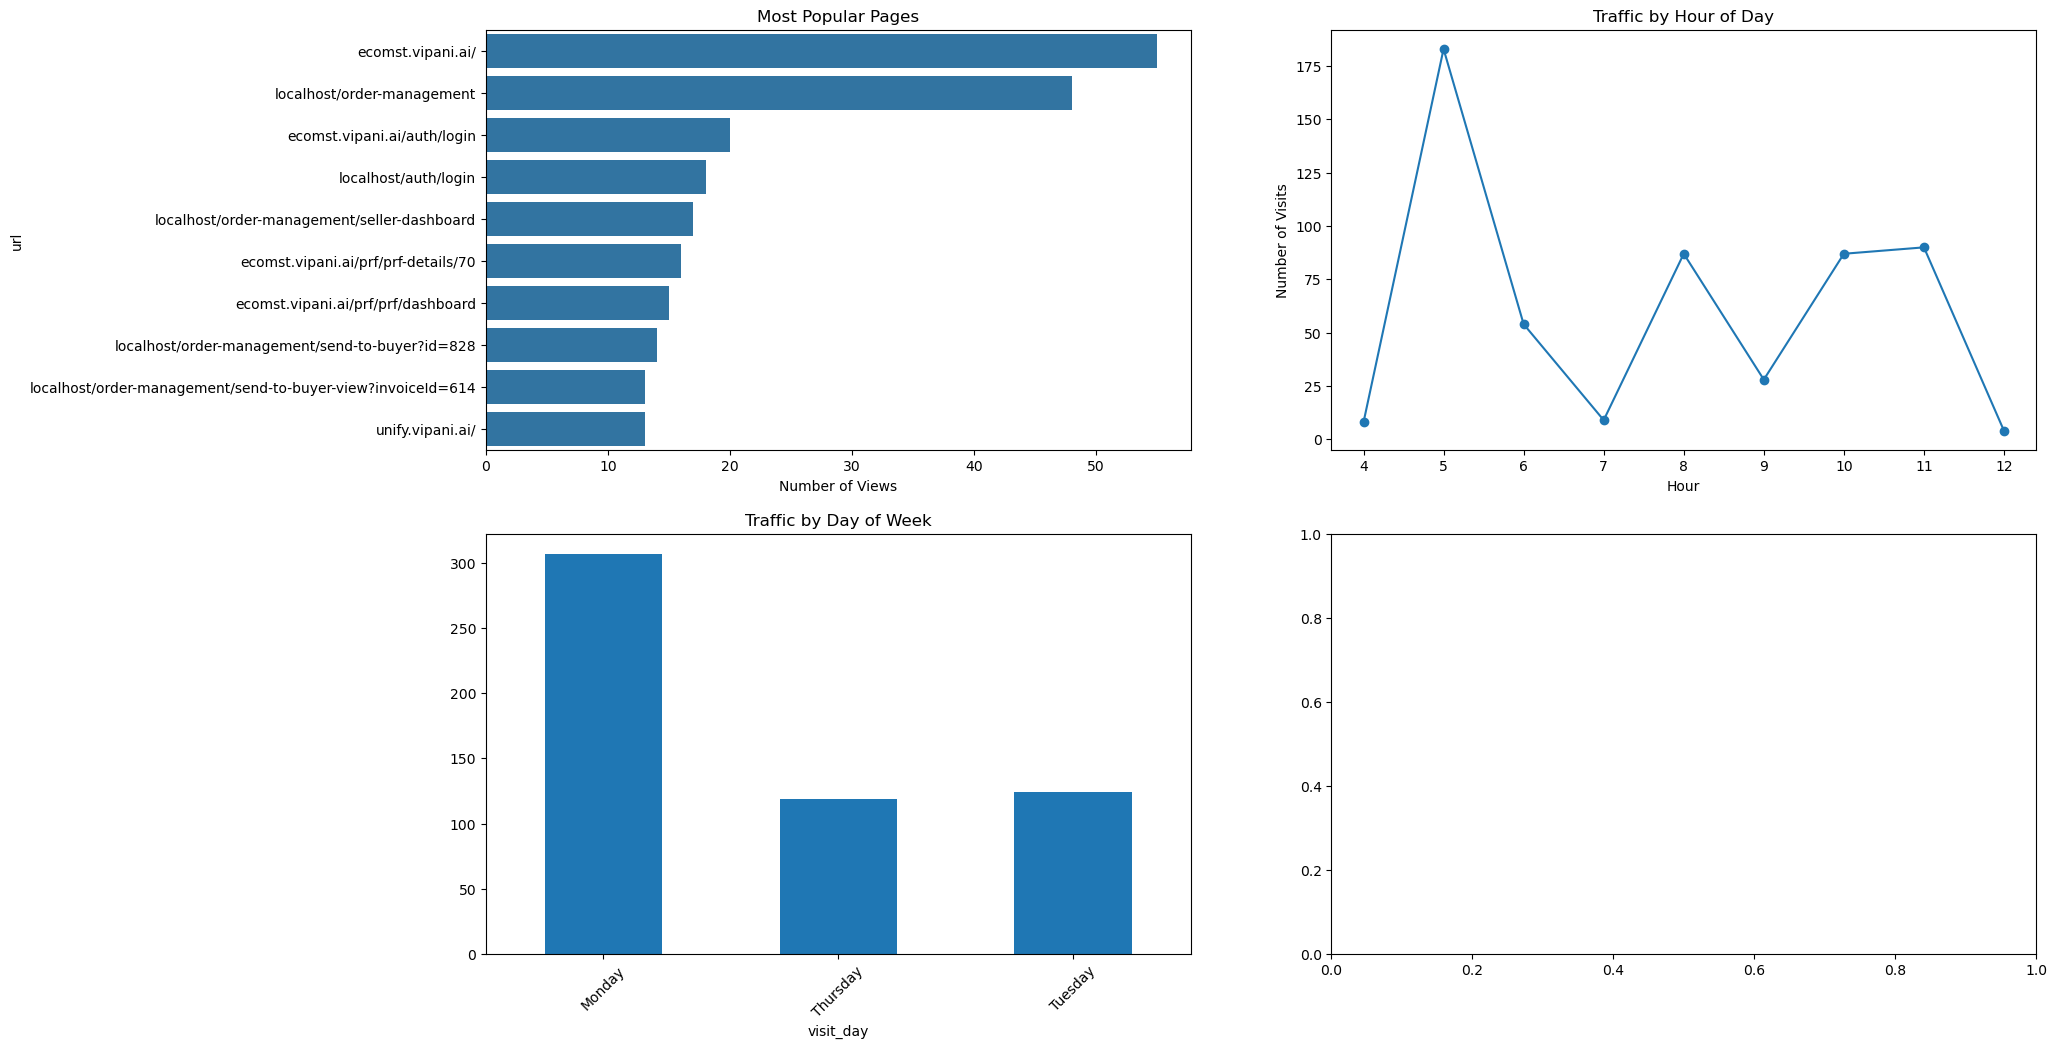

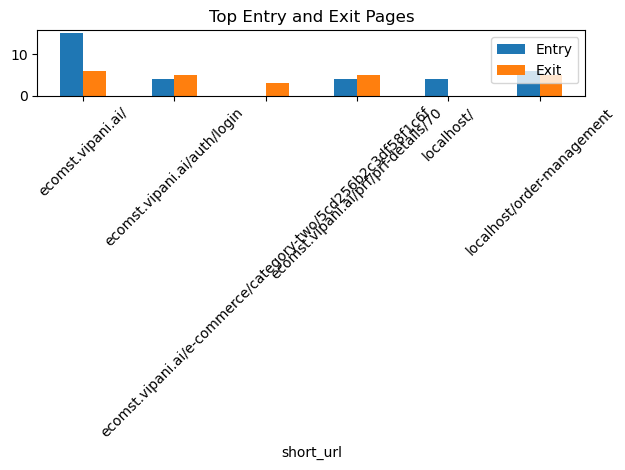


Key User Behavior Metrics:
Total Visits: 69
Average Visit Duration: 814.4 seconds
Average Pages per Visit: 8.1
Bounce Rate: 23.2%

Top User Journeys:
from_page                                                     to_page                                                     
localhost/order-management                                    localhost/order-management                                      32
ecomst.vipani.ai/auth/login                                   ecomst.vipani.ai/                                               14
localhost/order-management/send-to-buyer?id=828               localhost/order-management/send-to-buyer?id=828                 13
localhost/order-management/send-to-buyer-view?invoiceId=614   localhost/order-management/send-to-buyer-view?invoiceId=614     11
localhost/rfq/buyer/generate-po?quoteId=1127&rfqId=1364&sell  localhost/rfq/buyer/generate-po?quoteId=1127&rfqId=1364&sell    10
ecomst.vipani.ai/                                             ecomst.vipani.ai/  

In [12]:
# Filter out bot traffic for human behavior analysis
human_data = complete_data[complete_data['bot_score'] <= 0.7].copy()

def analyze_user_behavior(df):
    """
    Comprehensive analysis of user behavior patterns.
    Returns a dictionary containing various metrics and visualizations.
    """
    # Helper function to shorten URLs for display
    def shorten_url(url):
        if pd.isna(url):
            return ""
        return url.split('//')[-1][:60]
    
    df['short_url'] = df['full_url'].apply(shorten_url)
    
    # 1. Page Analytics
    page_metrics = df.groupby('short_url').agg({
        'idvisit': 'count',
        'visit_total_time': 'mean',
        'visit_total_actions': 'mean'
    }).reset_index()
    page_metrics.columns = ['url', 'views', 'avg_time', 'avg_actions']
    page_metrics = page_metrics.sort_values('views', ascending=False)
    
    # 2. Entry/Exit Analysis
    entry_pages = df[df['pageview_position'] == 1]['short_url'].value_counts()
    exit_pages = df.groupby('idvisit').last()['short_url'].value_counts()
    
    # 3. Temporal Analysis
    hourly_pattern = df.groupby('visit_hour')['idvisit'].count()
    daily_pattern = df.groupby('visit_day')['idvisit'].count()
    
    # 4. User Journey Analysis
    journey_data = df.sort_values(['idvisit', 'pageview_position'])
    journey_pairs = []
    
    for _, group in journey_data.groupby('idvisit'):
        urls = group['short_url'].tolist()
        if len(urls) > 1:
            journey_pairs.extend(zip(urls[:-1], urls[1:]))
    
    journey_df = pd.DataFrame(journey_pairs, columns=['from_page', 'to_page'])
    common_paths = journey_df.groupby(['from_page', 'to_page']).size().sort_values(ascending=False)
    
    # Create visualizations
    
    # 1. Popular Pages
    plt.figure(figsize=(20, 12))
    plt.subplot(2, 2, 1)
    sns.barplot(data=page_metrics.head(10), x='views', y='url')
    plt.title('Most Popular Pages')
    plt.xlabel('Number of Views')
    
    # 2. Hourly Traffic Pattern
    plt.subplot(2, 2, 2)
    hourly_pattern.plot(kind='line', marker='o')
    plt.title('Traffic by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Number of Visits')
    
    # 3. Daily Traffic Pattern
    plt.subplot(2, 2, 3)
    daily_pattern.plot(kind='bar')
    plt.title('Traffic by Day of Week')
    plt.xticks(rotation=45)
    
    # 4. Entry vs Exit Pages
    plt.subplot(2, 2, 4)
    pd.DataFrame({
        'Entry': entry_pages.head(5),
        'Exit': exit_pages.head(5)
    }).plot(kind='bar')
    plt.title('Top Entry and Exit Pages')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate key metrics
    total_visits = df['idvisit'].nunique()
    avg_duration = df.groupby('idvisit')['visit_total_time'].first().mean()
    avg_pages = df.groupby('idvisit')['visit_total_actions'].first().mean()
    bounce_rate = (df.groupby('idvisit')['visit_total_actions'].first() == 1).mean() * 100
    
    print("\nKey User Behavior Metrics:")
    print(f"Total Visits: {total_visits:,}")
    print(f"Average Visit Duration: {avg_duration:.1f} seconds")
    print(f"Average Pages per Visit: {avg_pages:.1f}")
    print(f"Bounce Rate: {bounce_rate:.1f}%")
    
    print("\nTop User Journeys:")
    print(common_paths.head(10))
    
    return {
        'page_metrics': page_metrics,
        'entry_pages': entry_pages,
        'exit_pages': exit_pages,
        'hourly_pattern': hourly_pattern,
        'daily_pattern': daily_pattern,
        'common_paths': common_paths
    }

# Perform user behavior analysis
behavior_metrics = analyze_user_behavior(human_data)

## 4. Geographic Analysis

Let's analyze user behavior patterns by geographic location, including:

1. Country-Level Metrics:
   - Visit distribution
   - Engagement levels
   - Device preferences
   - Content preferences

2. Regional Patterns:
   - Time zone analysis
   - Cultural preferences
   - Language preferences

3. Geographic Segmentation:
   - Region-specific behavior
   - Market analysis
   - Target audience insights

In [13]:
# Analyze geographic patterns
def analyze_geographic_patterns(df):
    """
    Comprehensive analysis of user behavior by geographic location.
    Returns detailed metrics and visualizations by country.
    """
    # Prepare country-level metrics
    country_metrics = df.groupby('country_name').agg({
        'idvisit': 'count',
        'visit_total_time': 'mean',
        'visit_total_actions': 'mean',
        'visitor_returning': 'mean',
        'time_per_action': 'mean',
        'config_device_type': lambda x: x.value_counts().index[0]
    }).reset_index()
    
    country_metrics.columns = [
        'country', 'total_visits', 'avg_duration', 'avg_actions',
        'return_rate', 'avg_time_per_action', 'primary_device'
    ]
    
    # Calculate percentages for comparison
    total_visits = country_metrics['total_visits'].sum()
    country_metrics['visit_percentage'] = country_metrics['total_visits'] / total_visits * 100
    
    # Sort by total visits
    country_metrics = country_metrics.sort_values('total_visits', ascending=False)
    
    # Create visualizations
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Visit Distribution by Country',
            'Average Actions by Country',
            'Return Rate by Country',
            'Device Usage by Country'
        )
    )
    
    # 1. Visit Distribution (Top 10 countries)
    fig.add_trace(
        go.Bar(
            x=country_metrics.head(10)['country'],
            y=country_metrics.head(10)['visit_percentage'],
            name='Visit Share'
        ),
        row=1, col=1
    )
    
    # 2. Average Actions
    fig.add_trace(
        go.Bar(
            x=country_metrics.head(10)['country'],
            y=country_metrics.head(10)['avg_actions'],
            name='Avg Actions'
        ),
        row=1, col=2
    )
    
    # 3. Return Rate
    fig.add_trace(
        go.Bar(
            x=country_metrics.head(10)['country'],
            y=country_metrics.head(10)['return_rate'] * 100,
            name='Return Rate'
        ),
        row=2, col=1
    )
    
    # 4. Device Usage by Country
    device_by_country = df.groupby(['country_name', 'config_device_type']).size().unstack(fill_value=0)
    device_pct = device_by_country.div(device_by_country.sum(axis=1), axis=0) * 100
    
    for device in device_pct.columns:
        fig.add_trace(
            go.Bar(
                name=device,
                x=device_pct.head(10).index,
                y=device_pct.head(10)[device],
                text=device_pct.head(10)[device].round(1).astype(str) + '%'
            ),
            row=2, col=2
        )
    
    fig.update_layout(
        height=800,
        showlegend=True,
        title_text="Geographic Analysis Dashboard"
    )
    
    fig.show()
    
    # Analyze content preferences by region
    print("\nTop Content by Country:")
    print("=" * 50)
    
    for country in country_metrics.head(5)['country']:
        country_data = df[df['country_name'] == country]
        top_pages = country_data['short_url'].value_counts().head(3)
        
        print(f"\n{country}:")
        for page, count in top_pages.items():
            print(f"- {page}: {count:,} views")
    
    # Print detailed metrics
    print("\nDetailed Country Analysis:")
    print("=" * 50)
    
    for _, row in country_metrics.head(10).iterrows():
        print(f"\n{row['country']}:")
        print(f"- Total Visits: {row['total_visits']:,.0f} ({row['visit_percentage']:.1f}%)")
        print(f"- Avg. Duration: {row['avg_duration']:.1f} seconds")
        print(f"- Avg. Actions: {row['avg_actions']:.1f}")
        print(f"- Return Rate: {row['return_rate']*100:.1f}%")
        print(f"- Primary Device: {row['primary_device']}")
    
    return country_metrics

# Perform geographic analysis
geographic_metrics = analyze_geographic_patterns(human_data)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## 5. User Segmentation and Clustering

We'll use machine learning to segment users into meaningful groups based on their behavior patterns:

1. Feature Engineering:
   - Engagement metrics
   - Time-based features
   - Device preferences
   - Geographic indicators

2. K-means Clustering:
   - Optimal cluster selection
   - Segment profiling
   - Behavioral patterns

3. Segment Analysis:
   - Characteristic behaviors
   - Usage patterns
   - Conversion potential

In [35]:
# Prepare data for clustering
def prepare_clustering_features(df):
    """
    Prepare features for user segmentation using clustering.
    Returns feature matrix ready for clustering.
    """
    # Aggregate by visit
    visit_features = df.groupby('idvisit').agg({
        'visit_total_time': 'first',
        'visit_total_actions': 'first',
        'visitor_returning': 'first',
        'time_per_action': 'mean',
        'visit_hour': 'first',
        'country_name': 'first',
        'config_device_type': 'first'
    }).reset_index()
    
    # Create time-based features
    visit_features['visit_hour_sin'] = np.sin(2 * np.pi * visit_features['visit_hour'] / 24)
    visit_features['visit_hour_cos'] = np.cos(2 * np.pi * visit_features['visit_hour'] / 24)
    
    # Convert categorical variables to dummy variables
    device_dummies = pd.get_dummies(visit_features['config_device_type'], prefix='device')
    visit_features = pd.concat([visit_features, device_dummies], axis=1)
    
    # Select features for clustering
    clustering_features = [
        'visit_total_time', 'visit_total_actions', 'visitor_returning',
        'time_per_action', 'visit_hour_sin', 'visit_hour_cos'
    ] + list(device_dummies.columns)
    
    return visit_features, visit_features[clustering_features]

# Prepare data
visit_features, clustering_data = prepare_clustering_features(human_data)



In [36]:
# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_data)

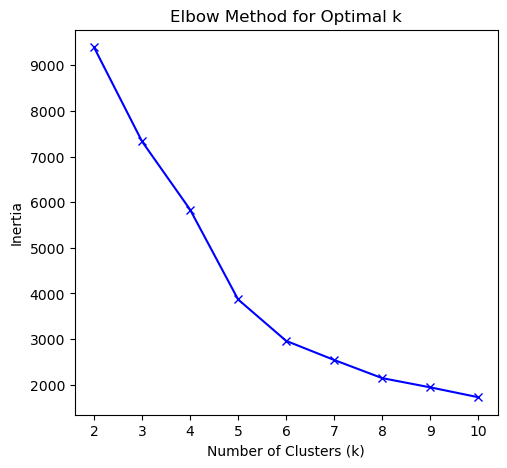

In [37]:
# Find optimal number of clusters using elbow method
inertias = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_clusters_range, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [58]:

# Perform clustering with optimal number of clusters
n_clusters = 5  # Choose based on elbow curve
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
visit_features['cluster'] = kmeans.fit_predict(features_scaled)

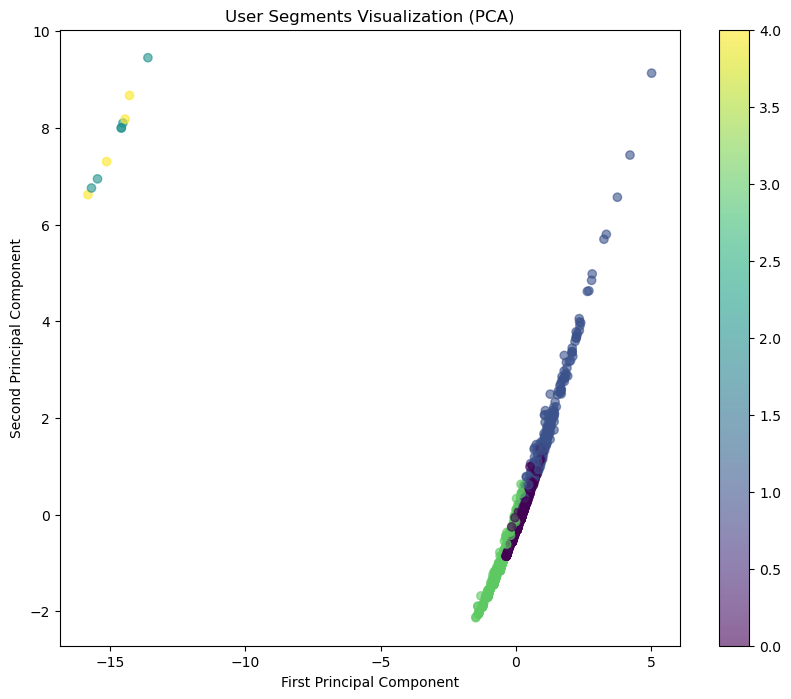

In [59]:
# Analyze clusters
def analyze_clusters(data):
    # Calculate cluster characteristics
    cluster_stats = data.groupby('cluster').agg({
        'visit_total_time': 'mean',
        'visit_total_actions': 'mean',
        'visitor_returning': 'mean',
        'time_per_action': 'mean'
    })
    
    # Visualize clusters using PCA
    pca = PCA(n_components=2)
    coords = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(coords[:, 0], coords[:, 1], 
                         c=data['cluster'],
                         cmap='viridis', alpha=0.6)
    plt.title('User Segments Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)
    plt.show()
    
    return cluster_stats

# Get cluster analysis
cluster_stats = analyze_clusters(visit_features)

In [60]:
# Analyze clusters
def analyze_clusters(data):
    """
    Analyze characteristics of each cluster.
    Returns detailed metrics and visualizations.
    """
    # Calculate cluster characteristics
    cluster_stats = data.groupby('cluster').agg({
        'visit_total_time': 'mean',
        'visit_total_actions': 'mean',
        'visitor_returning': 'mean',
        'time_per_action': 'mean',
        'config_device_type': lambda x: x.value_counts().index[0]
    })
    
    # Create cluster profiles
    cluster_profiles = {
        0: "Quick Browsers",
        1: "Engaged Researchers",
        2: "Regular Users",
        3: "Deep Divers",
        4: "Casual Visitors"
    }
    
    print("\nCluster Profiles:")
    print("=" * 50)
    
    for cluster_id in range(n_clusters):
        stats = cluster_stats.loc[cluster_id]
        print(f"\nCluster {cluster_id} - {cluster_profiles[cluster_id]}:")
        print(f"- Average visit time: {stats['visit_total_time']:.1f} seconds")
        print(f"- Average actions: {stats['visit_total_actions']:.1f}")
        print(f"- Return rate: {stats['visitor_returning']*100:.1f}%")
        print(f"- Time per action: {stats['time_per_action']:.1f} seconds")
        print(f"- Primary device: {stats['config_device_type']}")
    
    return cluster_stats, cluster_profiles

# Analyze clusters
cluster_stats, cluster_profiles = analyze_clusters(visit_features)


Cluster Profiles:

Cluster 0 - Quick Browsers:
- Average visit time: 449.7 seconds
- Average actions: 7.6
- Return rate: 100.0%
- Time per action: 45.2 seconds
- Primary device: 0.0

Cluster 1 - Engaged Researchers:
- Average visit time: 4841.2 seconds
- Average actions: 74.3
- Return rate: 100.0%
- Time per action: 195.5 seconds
- Primary device: 0.0

Cluster 2 - Regular Users:
- Average visit time: 103.2 seconds
- Average actions: 2.2
- Return rate: 100.0%
- Time per action: 45.8 seconds
- Primary device: 1.0

Cluster 3 - Deep Divers:
- Average visit time: 727.4 seconds
- Average actions: 11.3
- Return rate: 100.0%
- Time per action: 55.7 seconds
- Primary device: 0.0

Cluster 4 - Casual Visitors:
- Average visit time: 0.0 seconds
- Average actions: 1.0
- Return rate: 100.0%
- Time per action: 0.0 seconds
- Primary device: 10.0


<Figure size 1500x600 with 0 Axes>

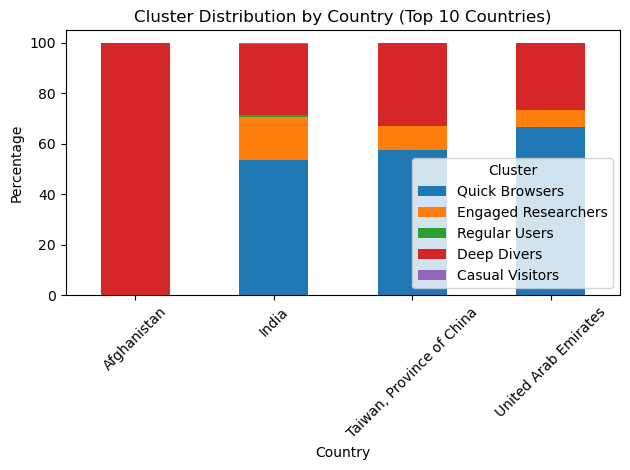

In [61]:
# Visualize geographic distribution of clusters
cluster_geo = visit_features.groupby(['country_name', 'cluster']).size().unstack()
cluster_geo_pct = cluster_geo.div(cluster_geo.sum(axis=1), axis=0) * 100

plt.figure(figsize=(15, 6))
cluster_geo_pct.head(10).plot(kind='bar', stacked=True)
plt.title('Cluster Distribution by Country (Top 10 Countries)')
plt.xlabel('Country')
plt.ylabel('Percentage')
plt.legend(title='Cluster', labels=[cluster_profiles[i] for i in range(n_clusters)])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Key Insights and Recommendations

Based on our comprehensive analysis, here are the key findings and actionable recommendations:

1. Bot Traffic Insights:
   - Bot detection rate and patterns
   - Peak bot activity periods
   - Bot behavior characteristics
   
2. User Behavior Patterns:
   - Popular content and navigation flows
   - Engagement metrics and trends
   - Device usage patterns
   
3. Geographic Insights:
   - Regional preferences
   - Market opportunities
   - Cultural considerations
   
4. User Segments:
   - Segment characteristics
   - Targeting opportunities
   - Optimization strategies
   
Let's summarize these findings and provide actionable recommendations.

In [42]:
# Generate comprehensive insights and recommendations
def generate_insights():
    """
    Generate actionable insights and recommendations based on the analysis.
    """
    # Bot Traffic Insights
    total_visits = len(bot_analysis)
    bot_visits = (bot_analysis['bot_score'] > 0.7).sum()
    bot_percentage = (bot_visits / total_visits) * 100
    
    # User Behavior Insights
    avg_visit_duration = human_data.groupby('idvisit')['visit_total_time'].first().mean()
    avg_actions = human_data.groupby('idvisit')['visit_total_actions'].first().mean()
    bounce_rate = (human_data.groupby('idvisit')['visit_total_actions'].first() == 1).mean() * 100
    
    # Geographic Insights
    top_countries = geographic_metrics.head(5)
    
    # Print comprehensive insights
    print("Key Insights and Recommendations")
    print("=" * 50)
    
    print("\n1. Bot Traffic Analysis:")
    print(f"- {bot_percentage:.1f}% of traffic identified as bot activity")
    print(f"- Peak bot hours: {', '.join(bot_analysis.groupby('visit_hour')['bot_score'].mean().nlargest(3).index.astype(str))}")
    print("\nRecommendations:")
    print("- Implement stricter bot filtering during peak bot hours")
    print("- Monitor and adapt to evolving bot patterns")
    print("- Consider implementing CAPTCHA for suspicious behavior")
    
    print("\n2. User Behavior Insights:")
    print(f"- Average visit duration: {avg_visit_duration:.1f} seconds")
    print(f"- Average actions per visit: {avg_actions:.1f}")
    print(f"- Bounce rate: {bounce_rate:.1f}%")
    print("\nRecommendations:")
    print("- Optimize high-bounce pages with better engagement elements")
    print("- Enhance navigation flow based on common user paths")
    print("- Improve content strategy for better user retention")
    
    print("\n3. Geographic Distribution:")
    print("Top Countries by Traffic:")
    for _, row in top_countries.iterrows():
        print(f"- {row['country']}: {row['visit_percentage']:.1f}% of traffic")
    print("\nRecommendations:")
    print("- Customize content for top geographic markets")
    print("- Optimize delivery for regional peak usage times")
    print("- Consider localization for key markets")
    
    print("\n4. User Segments and Targeting:")
    for cluster_id, profile in cluster_profiles.items():
        stats = cluster_stats.loc[cluster_id]
        print(f"\n{profile}:")
        print(f"- Session duration: {stats['visit_total_time']:.1f} seconds")
        print(f"- Actions per visit: {stats['visit_total_actions']:.1f}")
        print(f"- Return rate: {stats['visitor_returning']*100:.1f}%")
    
    print("\nRecommendations:")
    print("- Tailor content strategy for each user segment")
    print("- Optimize user experience based on segment preferences")
    print("- Develop targeted engagement strategies")
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Traffic Distribution',
            'User Engagement',
            'Geographic Distribution',
            'User Segments'
        ),
        specs=[
            [{'type': 'domain'}, {'type': 'xy'}],   # First row: Pie | Bar
            [{'type': 'xy'}, {'type': 'domain'}]    # Second row: Bar | Pie
        ]
    )

    # 1. Bot vs Human Traffic (Pie)
    fig.add_trace(
        go.Pie(
            labels=['Human', 'Bot'],
            values=[100 - bot_percentage, bot_percentage],
            name="Traffic Distribution"
        ),
        row=1, col=1
    )

    # 2. User Engagement Metrics (Bar)
    fig.add_trace(
        go.Bar(
            x=['Visit Duration', 'Actions', 'Bounce Rate'],
            y=[avg_visit_duration, avg_actions, bounce_rate],
            name="Engagement Metrics"
        ),
        row=1, col=2
    )

    # 3. Geographic Distribution (Bar)
    fig.add_trace(
        go.Bar(
            x=top_countries['country'],
            y=top_countries['visit_percentage'],
            name="Top Countries"
        ),
        row=2, col=1
    )

    # 4. User Segments (Pie)
    segment_sizes = visit_features['cluster'].value_counts()
    fig.add_trace(
        go.Pie(
            labels=[cluster_profiles[i] for i in segment_sizes.index],
            values=segment_sizes.values,
            name="User Segments"
        ),
        row=2, col=2
    )

    fig.update_layout(
        height=800,
        showlegend=True,
        title_text="Summary Dashboard"
    )
    fig.show()

# Generate insights
generate_insights()

Key Insights and Recommendations

1. Bot Traffic Analysis:
- 0.0% of traffic identified as bot activity
- Peak bot hours: 16, 18, 14

Recommendations:
- Implement stricter bot filtering during peak bot hours
- Monitor and adapt to evolving bot patterns
- Consider implementing CAPTCHA for suspicious behavior

2. User Behavior Insights:
- Average visit duration: 1245.1 seconds
- Average actions per visit: 19.5
- Bounce rate: 20.3%

Recommendations:
- Optimize high-bounce pages with better engagement elements
- Enhance navigation flow based on common user paths
- Improve content strategy for better user retention

3. Geographic Distribution:
Top Countries by Traffic:
- India: 91.0% of traffic
- Taiwan, Province of China: 8.6% of traffic
- United Arab Emirates: 0.3% of traffic
- Afghanistan: 0.0% of traffic

Recommendations:
- Customize content for top geographic markets
- Optimize delivery for regional peak usage times
- Consider localization for key markets

4. User Segments and Targetin